In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [4]:
transform = transforms.ToTensor()

In [5]:
train_data = datasets.MNIST(root='../Datasets', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='../Datasets', train=False, download=True, transform=transform)

In [6]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Datasets
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Datasets
    Split: Test
    StandardTransform
Transform: ToTensor()

In [8]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10)

In [9]:
# 1 COLOR CHANNEL, 6 FILTERS (OUTPUT CHANNEL), 3by3 KERNEL, STRIDE = 1
conv1 = nn.Conv2d(1, 6, 3, 1) # 6 filters -> pooling -> conv2

# 6 Input from conv1, 16 FILTERS (OUTPUT CHANNEL), 3by3 KERNEL, STRIDE = 1
conv2 = nn.Conv2d(6, 16, 3, 1)

In [10]:
for i, (X_train, y_train) in enumerate(train_data):
    break

In [11]:
x = X_train.view(1, 1, 28, 28)
x

tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [12]:
x = F.relu(conv1(x))

In [13]:
x.shape

torch.Size([1, 6, 26, 26])

In [14]:
x = F.max_pool2d(x, 2, 2)

In [15]:
x.shape

torch.Size([1, 6, 13, 13])

In [16]:
x = F.relu(conv2(x))

In [17]:
x.shape

torch.Size([1, 16, 11, 11])

In [18]:
x = F.max_pool2d(x, 2, 2)

In [19]:
x.shape

torch.Size([1, 16, 5, 5])

In [20]:
x.view(-1, 16*5*5).shape

torch.Size([1, 400])

## Define model

In [21]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16*5*5)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [22]:
torch.manual_seed(42)
model = ConvolutionalNetwork()

In [23]:
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [24]:
for param in model.parameters():
    print(param.numel())

54
6
864
16
48000
120
10080
84
840
10


In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [26]:
import time 
current_time = time.time()

# VARIABLES
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# FOR LOOP EPOCHS
for i in range(epochs):
    tr_cor = 0
    te_cor = 0

    # FOR LOOP TRAIN
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1

        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        batch_cor = (predicted == y_train).sum()
        tr_cor += batch_cor

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%600 == 0:
            print(f'Epoch: {i}  Batch: {b}  Loss: {loss.item()}')

    train_correct.append(tr_cor)
    train_losses.append(loss)
    
    # FOR LOOP TEST
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            b += 1

            y_pred = model(X_test)
            loss = criterion(y_pred, y_test)

            predicted = torch.max(y_pred.data, 1)[1]
            te_cor = (predicted == y_test).sum()
    test_correct.append(te_cor)
    test_losses.append(loss)


total = time.time() - current_time
print(f'Durations: {total/60} minutes')

Epoch: 0  Batch: 600  Loss: 0.4505527913570404
Epoch: 0  Batch: 1200  Loss: 0.010748334228992462
Epoch: 0  Batch: 1800  Loss: 0.08667301386594772
Epoch: 0  Batch: 2400  Loss: 0.6175661683082581
Epoch: 0  Batch: 3000  Loss: 0.0010265919845551252
Epoch: 0  Batch: 3600  Loss: 0.025456950068473816
Epoch: 0  Batch: 4200  Loss: 1.7022473812103271
Epoch: 0  Batch: 4800  Loss: 0.002394947689026594
Epoch: 0  Batch: 5400  Loss: 5.085044540464878e-05
Epoch: 0  Batch: 6000  Loss: 0.18151195347309113
Epoch: 1  Batch: 600  Loss: 0.10983368009328842
Epoch: 1  Batch: 1200  Loss: 0.00010396691504865885
Epoch: 1  Batch: 1800  Loss: 0.07410154491662979
Epoch: 1  Batch: 2400  Loss: 0.03397189825773239
Epoch: 1  Batch: 3000  Loss: 0.002671924652531743
Epoch: 1  Batch: 3600  Loss: 0.03005843237042427
Epoch: 1  Batch: 4200  Loss: 0.06314687430858612
Epoch: 1  Batch: 4800  Loss: 0.8803056478500366
Epoch: 1  Batch: 5400  Loss: 0.02784602902829647
Epoch: 1  Batch: 6000  Loss: 0.10420787334442139
Epoch: 2  Batch

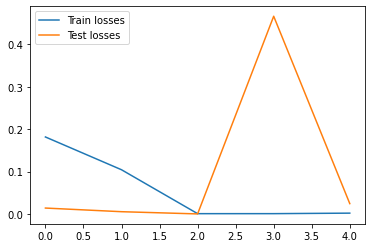

In [27]:
plt.plot(train_losses, label='Train losses')
plt.plot(test_losses, label='Test losses')
plt.legend()

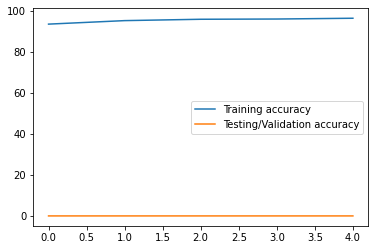

In [29]:
plt.plot([t/600 for t in train_correct], label='Training accuracy')
plt.plot([t/600 for t in test_correct], label='Testing/Validation accuracy')
plt.legend()

In [31]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [32]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_pred = model(X_test)
        predicted = torch.max(y_pred.data, 1)[1]
        correct = (predicted == y_test).sum()

In [33]:
print(correct / 10000)

tensor(0.9635)
